In [46]:
import os
import re
from io import BytesIO
import sys
import pandas as pd
import requests
import json
import time
from PIL import Image
from matplotlib import pyplot
from tqdm.auto import tqdm

In [2]:
MODEL_TYPE = 'image-pair-ranking-elm-v1'
# MODEL_TYPE = 'image-pair-ranking-linear'

INPUT_TYPE = 'clip'

DATASET = 'environmental'

In [3]:
SCORE_DIR = './data/get-image-rank-sigma-scores-by-model-id/'

LIST_DIR = f'./data/{DATASET}'

# BASE_URL = 'http://123.176.98.90:8764'
BASE_URL = 'http://192.168.3.1:8111'

In [4]:
os.makedirs(SCORE_DIR, exist_ok=True)
os.makedirs(LIST_DIR, exist_ok=True)

In [5]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.ensemble.ensemble_helpers import Binning, SigmaScoresWithEntropy

# get models

## load list

In [6]:
model_list = pd.read_csv(os.path.join(LIST_DIR, f'model_list.csv'), index_col='model_file_hash')

## filter list

In [7]:
model_list['model_type'].unique(), model_list['input_type'].unique()

(array(['xgboost-rank-pairwise', 'image-pair-ranking-linear',
        'image-pair-ranking-elm-v1',
        'image-pair-independent-approximation-v1', nan], dtype=object),
 array(['clip', 'embedding-positive', 'embedding-negative', 'embedding',
        'positive-phrase-vector', 'negative-phrase-vector',
        'phrase-vector', nan], dtype=object))

In [8]:
model_ids = list(model_list.query(f'model_type == "{MODEL_TYPE}" and input_type == "{INPUT_TYPE}"')['model_id'].dropna().astype(int))

# get sigma-scores

In [10]:
url = f'{BASE_URL}/sigma-score/get-image-rank-sigma-scores-by-model-id'

for model_id in tqdm(model_ids, leave=False):
    
    output_path = os.path.join(SCORE_DIR, f'{model_id}.json')
    
    if os.path.exists(output_path):
        result = json.load(open(output_path))
        if len(result) > 1:
            continue
    
    data = requests.get(f'{url}?model_id={model_id}')
    
    result = eval(data.content)
    
    json.dump(result, open(output_path, 'wt'))

  0%|          | 0/42 [00:00<?, ?it/s]

# get dataset

In [11]:
ensembled_sigma_scores = list()

for model_id in tqdm(model_ids, leave=False):
    
    output_path = os.path.join(SCORE_DIR, f'{model_id}.json')
    
    result = json.load(open(output_path))
    
    if len(result) <= 1:
        continue
    
    result = pd.DataFrame(result)
    result.drop_duplicates('image_hash', keep='first', inplace=True)
    result.set_index('image_hash', inplace=True)
    
    result = result[['sigma_score']]
    result.columns = [model_id]
    
    ensembled_sigma_scores.append(result)

  0%|          | 0/42 [00:00<?, ?it/s]

In [12]:
ensembled_sigma_scores = pd.concat(ensembled_sigma_scores, axis=1, join='inner')
selected_model_ids = ensembled_sigma_scores.columns

In [13]:
ensembled_sigma_scores

,2043,1959,1876,1794,1711,1639,1625,1286,1202,1115,1036
image_hash,,,,,,,,,,,
712bb7f66e2d08fe4862029c5023fd98e3f9e9b4322596c2c2cead1633b45ce6,2.174501,2.148513,2.168304,2.157182,2.369616,2.147586,2.229080,1.885270,2.077141,2.075000,2.060488
5fb76a163f58bcf139a2982f84811d989b9d247885fe284b25b8fb93a03306b6,2.148869,2.115278,2.134281,2.040377,2.169973,2.063108,2.129667,2.258218,2.229419,2.113395,2.195931
061839fbb30cdff33be00fdcc53c6e47a53e9ca2ac75d39af9d559876bdd66cf,2.099567,1.971926,2.076418,2.023127,2.109577,2.282314,2.342834,2.268940,2.259225,2.308493,2.392524
f5446efa6218a18994d5cbf7b7c09efe1cfbef5e7d6a1961e05d038320391184,2.086223,2.103250,2.212975,2.242715,2.102339,2.153761,2.126978,2.232406,2.234813,2.300997,2.203932
93f152ba54986f69ed17e340a050f882960eca66b44d66cfbd1f285b5abd189e,2.009049,2.042581,2.000189,2.178513,2.070844,2.044718,2.211158,2.098926,2.334145,2.354109,2.104244
...,...,...,...,...,...,...,...,...,...,...,...
3bc847a56c1a5e2ee1233870f741ab222aa4122eda022fe7a056105af6e1d640,-3.959074,-4.027252,-3.925047,-3.916942,-3.906999,-4.027246,-3.946308,-4.449816,-3.978691,-4.270200,-4.122597
d7ef6686d22b902726a26e07a117c52c184724d58b8de0326db64316faa9f489,-4.073166,-3.647911,-3.901565,-3.878943,-3.784930,-4.048457,-3.718282,-3.802052,-3.702292,-3.944789,-3.757962
8ca96ffd31061cdbcf220ecf34b6c80b71a9773222be0ebb2006260b624f93f5,-4.469969,-4.485251,-4.335705,-4.128678,-4.530227,-4.393539,-4.579994,-4.418290,-4.409412,-4.194598,-4.366267


# analysis

In [14]:
values = ensembled_sigma_scores[selected_model_ids].values.copy()

Text(0, 0.5, 'sigma_score_var')

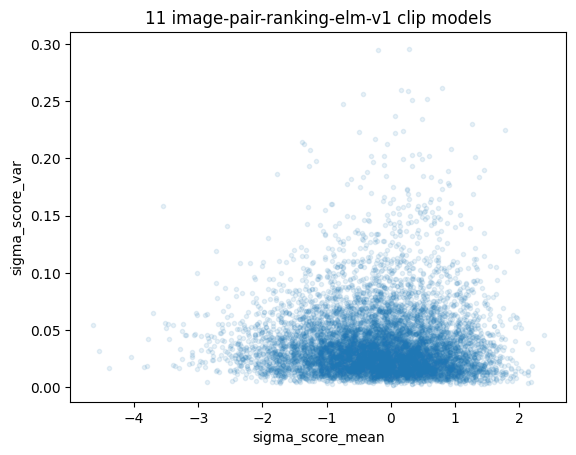

In [15]:
pyplot.plot(values.mean(axis=-1), values.var(axis=-1), '.', alpha=0.1)
pyplot.title(f'{len(selected_model_ids)} {MODEL_TYPE} {INPUT_TYPE} models')
pyplot.xlabel('sigma_score_mean')
pyplot.ylabel('sigma_score_var')

## get entropy

In [16]:
binning = Binning(start=-2, count=8, step=0.5)
binning.thresholds

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [17]:
sigma_scores = SigmaScoresWithEntropy(sigma_scores=values, binning=binning)

In [18]:
stats = sigma_scores.to_dataframe()
stats.index = ensembled_sigma_scores.index

In [19]:
stats

,sigma_score_mean,sigma_score_var,sigma_score_max,sigma_score_min,entropy,n_models,num_below_start,num_above_end,bin_start,bin_count,bin_step,p
image_hash,,,,,,,,,,,,
712bb7f66e2d08fe4862029c5023fd98e3f9e9b4322596c2c2cead1633b45ce6,2.135698,0.012932,2.369616,1.885270,-0.0,0,0,11,-2,8,0.5,0;0;0;0;0;0;0;11
5fb76a163f58bcf139a2982f84811d989b9d247885fe284b25b8fb93a03306b6,2.145320,0.003915,2.258218,2.040377,-0.0,0,0,11,-2,8,0.5,0;0;0;0;0;0;0;11
061839fbb30cdff33be00fdcc53c6e47a53e9ca2ac75d39af9d559876bdd66cf,2.194086,0.018248,2.392524,1.971926,-0.0,0,0,11,-2,8,0.5,0;0;0;0;0;0;0;11
f5446efa6218a18994d5cbf7b7c09efe1cfbef5e7d6a1961e05d038320391184,2.181854,0.004560,2.300997,2.086223,-0.0,0,0,11,-2,8,0.5,0;0;0;0;0;0;0;11
93f152ba54986f69ed17e340a050f882960eca66b44d66cfbd1f285b5abd189e,2.131680,0.013848,2.354109,2.000189,-0.0,0,0,11,-2,8,0.5,0;0;0;0;0;0;0;11
...,...,...,...,...,...,...,...,...,...,...,...,...
3bc847a56c1a5e2ee1233870f741ab222aa4122eda022fe7a056105af6e1d640,-4.048198,0.026589,-3.906999,-4.449816,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
d7ef6686d22b902726a26e07a117c52c184724d58b8de0326db64316faa9f489,-3.841850,0.017814,-3.647911,-4.073166,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
8ca96ffd31061cdbcf220ecf34b6c80b71a9773222be0ebb2006260b624f93f5,-4.391994,0.016578,-4.128678,-4.579994,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0


## plot

Text(0.5, 0.98, 'fixed steps, 8 bins, 11 image-pair-ranking-elm-v1 clip models')

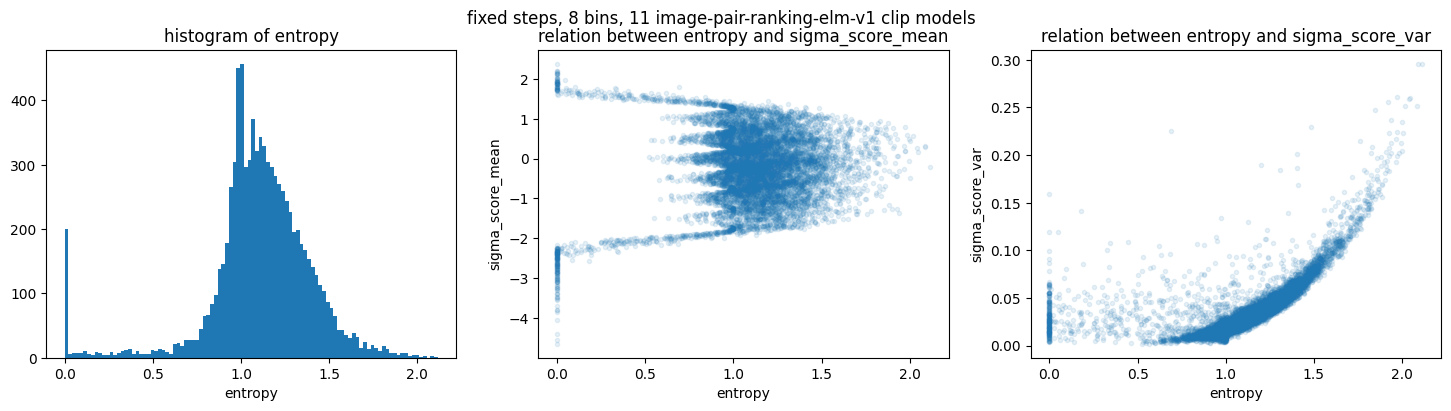

In [20]:
figure = pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)

pyplot.hist(stats['entropy'], bins=100)
pyplot.xlabel('entropy')
pyplot.title('histogram of entropy')

pyplot.subplot(1, 3, 2)

pyplot.plot(stats['entropy'], stats['sigma_score_mean'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_mean')
pyplot.title('relation between entropy and sigma_score_mean')

pyplot.subplot(1, 3, 3)

pyplot.plot(stats['entropy'], stats['sigma_score_var'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_var')
pyplot.title('relation between entropy and sigma_score_var')

figure.suptitle(f'fixed steps, {len(binning.thresholds)} bins, {len(selected_model_ids)} {MODEL_TYPE} {INPUT_TYPE} models')

# check

In [22]:
selected = stats.query('entropy == 0 and sigma_score_mean < -2')
selected

,sigma_score_mean,sigma_score_var,sigma_score_max,sigma_score_min,entropy,n_models,num_below_start,num_above_end,bin_start,bin_count,bin_step,p
image_hash,,,,,,,,,,,,
2edb0bd4336f8354fb478ee414b68acfc68126e6771f829fbf064bab4fb4596f,-2.363047,0.019161,-2.138962,-2.607955,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
daf63c2e93d4cfce61c0762f3687f6d3e594c1471088e60c9686a41620c476d3,-2.251772,0.011514,-2.094854,-2.432123,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
e8d2a50e77790c2065a4c7ed6b78d2054f65f59ff72021c30e47933d9b9a377c,-2.359506,0.043683,-2.023801,-2.749969,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
b1c3f73de47b888535ebf22d69424662b6ca6550b1afad42061a26a691e8fc2b,-2.298417,0.021870,-2.137773,-2.655106,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
ee4aabfbef5c09dce088845ba3a3f8906ce202c72415fbbf19804b770574b1b1,-2.331097,0.027594,-2.091848,-2.725530,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
...,...,...,...,...,...,...,...,...,...,...,...,...
3bc847a56c1a5e2ee1233870f741ab222aa4122eda022fe7a056105af6e1d640,-4.048198,0.026589,-3.906999,-4.449816,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
d7ef6686d22b902726a26e07a117c52c184724d58b8de0326db64316faa9f489,-3.841850,0.017814,-3.647911,-4.073166,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0
8ca96ffd31061cdbcf220ecf34b6c80b71a9773222be0ebb2006260b624f93f5,-4.391994,0.016578,-4.128678,-4.579994,-0.0,11,11,0,-2,8,0.5,11;0;0;0;0;0;0;0


In [42]:
def get_job_by_hash(image_hash):

    url = f'{BASE_URL}/job/get-completed-job-by-hash'

    data = requests.get(f'{url}?image_hash={image_hash}')

    result = json.loads(data.content)

    return result
    
def get_image_by_job_uuid(job_uuid):

    url = f'{BASE_URL}/get-image-by-job-uuid'

    data = requests.get(f'{url}/{job_uuid}')
    
    return data.content

In [48]:
job_info = get_job_by_hash(selected.index[0])
job_info

{'task_type': 'image_generation_task',
 'uuid': '9c513fd9-6b33-40c2-8e44-09eda15d2a10',
 'model_name': 'v1-5-pruned-emaonly',
 'model_file_name': 'v1-5-pruned-emaonly',
 'model_file_path': 'input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors',
 'sd_model_hash': None,
 'task_creation_time': '2023-10-23T19:20:01.498000',
 'task_start_time': '2023-10-23 19:24:29',
 'task_completion_time': '2023-10-23 19:24:31',
 'task_error_str': None,
 'task_input_dict': {'positive_prompt': 'environmental 2D, side scrolling, video game, 2D environmental, side view, 2D side scrolling, tile based environment, 2D side scrolling video game, ultra high res, female focus, looking at viewer, action pose running, large penis, white box, yellow eyes, beautiful face, green eyes, best, full-package futanari, checkerboard cookie, necklace, face focus, hair ornament, night, fewer digits, warm lights, ((seductive smile:1.1))',
  'negative_prompt': 'ugly, bad hand, cartoon, deleted, liquid clit, nude, (m

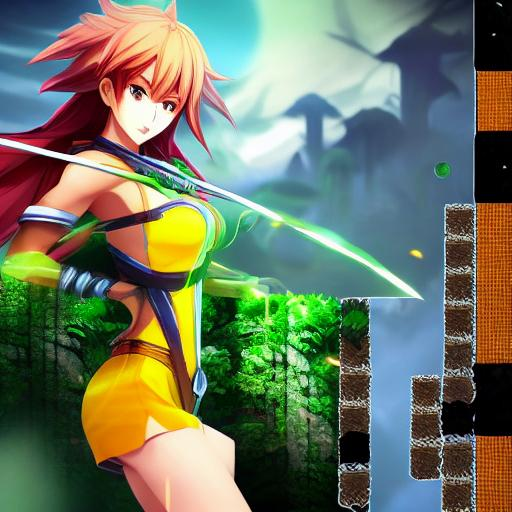

In [49]:
Image.open(BytesIO(get_image_by_job_uuid(job_info['uuid'])))

# dowload list (no need to run)

### list models

In [ ]:
url = f'{BASE_URL}/models/rank-embedding/list-models'

In [ ]:
data = requests.get(f'{url}?dataset={DATASET}')

In [ ]:
model_list = eval(data.content)

In [ ]:
model_list = pd.DataFrame(model_list)
model_list.set_index('model_file_hash', inplace=True)

### get model ids

In [ ]:
url = f'{BASE_URL}/models/get-id'

In [ ]:
model_ids = dict()

for model_hash in tqdm(model_list.index, leave=False):
    
    data = requests.get(f'{url}?model_hash={model_hash}')
    
    try:
        result = eval(data.content)
    except:
        model_ids[result] = None
        continue
    
    if type(result) != int:
        model_ids[result] = None
        continue
    
    model_ids[result] = model_hash

In [ ]:
model_list['model_id'] = None
for model_id, model_hash in model_ids.items():
    model_list.loc[model_hash, 'model_id'] = model_id

### save list

In [ ]:
model_list.to_csv(os.path.join(LIST_DIR, f'model_list.csv'))